In [1]:
import pandas as pd
import decode_eeg
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sista
import pingouin

np.random.seed(42)
%load_ext autoreload
%autoreload 2

In [2]:
# Experiment setup
experiment_name1 = '1801'
experiment_name2 = '1901'
experiment_name3 = '1902'
data_dir1 = f'./data/{experiment_name1}'
data_dir2 = f'./data/{experiment_name2}'
data_dir3 = f'./data/{experiment_name3}'
exp1 = decode_eeg.Experiment(experiment_name1,data_dir1)
exp2 = decode_eeg.Experiment(experiment_name2,data_dir2)
exp3 = decode_eeg.Experiment(experiment_name3,data_dir3)

## Single feature to conjunction

In [3]:
# Classification parameters and setup
time_window = 50
time_step = 25
trial_average = 20
n_splits = 1000
group_dict_list =  [{0:[1],1:[2]},{0:[2],1:[4]}]
wrangl = decode_eeg.Wrangler(exp1.info['times'],time_window,time_step,trial_average,n_splits,group_dict_list=group_dict_list)

sync_s2c = decode_eeg.Experiment_Syncer(experiments=[exp1,exp2,exp3],
                                    wrangler = wrangl,
                                    train_group = [experiment_name1,experiment_name2])

clfr = decode_eeg.Classification(wrangl,sync_s2c.nsub,num_labels=2)

In [4]:
# If you want to retrain classifiers, run this cell. Otherwise run next cell.

clfr.acc = np.zeros((clfr.nsub,len(group_dict_list),np.size(clfr.t),clfr.n_splits))*np.nan
clfr.acc_shuff = np.zeros((clfr.nsub,len(group_dict_list),np.size(clfr.t),clfr.n_splits))*np.nan
clfr.conf_mat = np.zeros((clfr.nsub,len(group_dict_list),np.size(clfr.t),clfr.n_splits,clfr.num_labels,clfr.num_labels))*np.nan

for isub,sub in enumerate(sync_s2c.matched_ids):
    print(isub)
    xdata_all,ydata_all = sync_s2c.load_eeg(sub)
    
    # Runs classification with 1vs2 and then 2vs4, also handles trial binning
    for xdata,ydata in sync_s2c.pairwise(xdata_all,ydata_all):
        xdata,ydata = sync_s2c.balance_labels(xdata,ydata)
        xdata,ydata = sync_s2c.average_trials(xdata,ydata)
        
        # Splits data into train and test based on sync.train_group
        xdata_train,xdata_test,ydata_train,ydata_test = sync_s2c.group_data(xdata,ydata)
        
        # Cross validation
        for X_train_all, X_test_all, y_train, y_test in wrangl.train_test_custom_split(xdata_train,xdata_test,ydata_train,ydata_test):
            X_test_all, y_test = wrangl.balance_labels(X_test_all,y_test)
            y_test_shuffle = np.random.permutation(y_test)
            for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
                    clfr.decode_pairwise(X_train,X_test,y_train,y_test,y_test_shuffle,isub)

# Set up interp object and save results.
interp_s2c = decode_eeg.Interpreter(clfr, subtitle = f'single_feature_to_conj_set_size_trialbin{trial_average}_')
interp_s2c.matched_ids = sync_s2c.matched_ids
interp_s2c.save_results(additional_values=['matched_ids'])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [4]:
# Set up interp object and load pre-existing results. Skip if you ran previous cell.
interp_s2c = decode_eeg.Interpreter()
interp_s2c.load_results('single_feature_to_conj_set_size_trialbin20.pickle')

## Single feature to single feature

In [5]:
# Classification parameters and setup
time_window = 50
time_step = 25
trial_average = 20
n_splits = 1000
group_dict_list =  [{0:[1],1:[2]},{0:[2],1:[4]}]
wrangl = decode_eeg.Wrangler(exp1.info['times'],time_window,time_step,trial_average,n_splits,group_dict_list=group_dict_list)

sync_s2s = decode_eeg.Experiment_Syncer(experiments=[exp1,exp2],
                                    wrangler = wrangl,
                                    train_group = [experiment_name1,experiment_name2])

clfr = decode_eeg.Classification(wrangl,sync_s2s.nsub,num_labels=2)

In [6]:
# If you want to retrain classifiers, run this cell. Otherwise run next cell.

clfr.acc = np.zeros((clfr.nsub,len(group_dict_list),np.size(clfr.t),clfr.n_splits))*np.nan
clfr.acc_shuff = np.zeros((clfr.nsub,len(group_dict_list),np.size(clfr.t),clfr.n_splits))*np.nan
clfr.conf_mat = np.zeros((clfr.nsub,len(group_dict_list),np.size(clfr.t),clfr.n_splits,clfr.num_labels,clfr.num_labels))*np.nan

for isub,sub in enumerate(sync_s2s.matched_ids):
    print(isub)
    xdata_all,ydata_all = sync_s2s.load_eeg(sub)
    
    # Runs classification with 1vs2 and then 2vs4, also handles trial binning
    for xdata,ydata in sync_s2s.pairwise(xdata_all,ydata_all):
        xdata,ydata = sync_s2s.balance_labels(xdata,ydata)
        xdata,ydata = sync_s2s.average_trials(xdata,ydata)
        
        # Splits data into train and test based on sync.train_group
        xdata,ydata = sync_s2s.group_data(xdata,ydata)

        # Cross validation
        for X_train_all, X_test_all, y_train, y_test in wrangl.train_test_split(xdata,ydata):
            X_test_all, y_test = wrangl.balance_labels(X_test_all,y_test)
            y_test_shuffle = np.random.permutation(y_test)
            for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
                    clfr.decode_pairwise(X_train,X_test,y_train,y_test,y_test_shuffle,isub)

# Set up interp object and save results. 
interp_s2s = decode_eeg.Interpreter(clfr, subtitle = f'single_feature_set_size_trialbin{trial_average}_')
interp_s2s.matched_ids = sync_s2s.matched_ids
interp_s2s.save_results(additional_values=['matched_ids'])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [6]:
# Set up interp object and load pre-existing results. Skip if you ran previous cell.
interp_s2s = decode_eeg.Interpreter()
interp_s2s.load_results('single_feature_set_size_trialbin20.pickle')

## Prepping conf mat data

In [7]:
# get confusions matrices, and drop subjects who aren't in both datasets
conj_conf = interp_s2c.conf_mat
sing_conf = interp_s2s.conf_mat
remove_subs_idx = np.isin(interp_s2s.matched_ids,interp_s2c.matched_ids)
sing_conf = sing_conf[remove_subs_idx]

In [18]:
# confusion matrices shape: [subject, ss pair, timepoint, fold, true ss, pred ss]
sing_conf.shape

(20, 2, 59, 1000, 2, 2)

In [10]:
def get_norm_sub_means(conf,ss_pair,ss):
    ''' Gets normalized predictions. Percent of trials of given condition predicted as 1 or 2.
        *This function is a bit confusing, so you should walk through it step by step.*
        
        Input:
        conf: confusion matrix [subject, ss pair, timepoint, fold, ss, ss]
        ss_pair: conf holds confusion matrices for 1vs2 (0th index) and 2vs4 (1st index)
        ss: grab predictions for the smaller or larger set size within the ss_pair 1/2 or 2/4
        Output:
        norm_sub_means: normalized confusion matrix for ss_pair and ss [subject, predicted ss]
    '''
    ss_pair_dict = {'1vs2':0,'2vs4':1}
    ss_pair_ss_dict = {'1vs2':{1:0,2:1},'2vs4':{2:0,4:1}}
    ss_pair_idx = ss_pair_dict[ss_pair]
    ss_idx = ss_pair_ss_dict[ss_pair][ss]

    sub_means = np.mean(np.mean(conf[:,ss_pair_idx][:,wrangl.t>250],2),1)[:,ss_idx]
    norm_sub_means = np.empty(sub_means.shape)
    for i in range(sub_means.shape[0]):
        norm_sub_means[i] = (sub_means[i] / sum(sub_means[i]))
    
    return norm_sub_means

## Set size 1vs2

In [334]:
sing1 = get_norm_sub_means(sing_conf,ss_pair='1vs2',ss=1)
sing2 = get_norm_sub_means(sing_conf,ss_pair='1vs2',ss=2)
conj1 = get_norm_sub_means(conj_conf,ss_pair='1vs2',ss=1)

sing1_percent1 = np.mean(sing1,0)[0]
sing2_percent1 = np.mean(sing2,0)[0]
conj1_percent1 = np.mean(conj1,0)[0]

In [335]:
data = np.concatenate([sing1[:,0],sing2[:,0],conj1[:,0]]).T
labels = np.repeat(['1 single-feature','2 single-feature','1 conjunction'],sing1.shape[0])
data_for_plotting = pd.DataFrame({'data':data,'labels':labels})

In [326]:
data_for_plotting.groupby('labels').mean().round(2)

,data
labels,
1 conjunction,0.65
1 single-feature,0.65
2 single-feature,0.35


In [302]:
data_for_plotting.groupby('labels').std().round(2)

,data
labels,
1 conjunction,0.12
1 single-feature,0.06
2 single-feature,0.07


In [303]:
# 1 single feature vs 1 conjunction
pingouin.ttest(    
    x=data_for_plotting[data_for_plotting['labels']=='1 single-feature']['data'],
    y=data_for_plotting[data_for_plotting['labels']=='1 conjunction']['data'],
    paired=True).round(3)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.002,19,two-sided,0.999,"[-0.06, 0.06]",0.0,0.232,0.05


In [304]:
# 2 single feature vs 1 conjunction
pingouin.ttest(    
    x=data_for_plotting[data_for_plotting['labels']=='2 single-feature']['data'],
    y=data_for_plotting[data_for_plotting['labels']=='1 conjunction']['data'],
    paired=True).round(3)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-9.014,19,two-sided,0.0,"[-0.37, -0.23]",3.086,4.944e+05,1.0


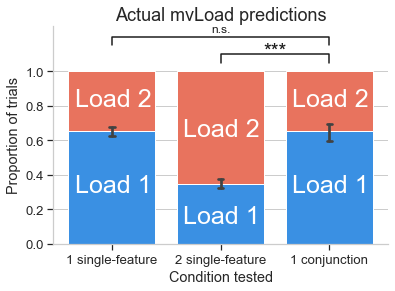

In [355]:
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

sns.barplot(x=[0,1,2], y=[1,1,1], color='tomato')
ax = sns.barplot(x=labels,y=data,data=data_for_plotting,color='dodgerblue', capsize=.05)

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.title('Actual mvLoad predictions', fontsize = 18)
ax.set_ylabel('Proportion of trials')
ax.set_xlabel('Condition tested')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.text(.01,.3,'Load 1',fontsize=25,c='w',ha='center');
ax.text(1+.01,.12,'Load 1',fontsize=25,c='w',ha='center');
ax.text(2+.01,.3,'Load 1',fontsize=25,c='w',ha='center');

ax.text(.01,.8,'Load 2',fontsize=25,c='w',ha='center');
ax.text(1+.01,.625,'Load 2',fontsize=25,c='w',ha='center');
ax.text(2+.01,.8,'Load 2',fontsize=25,c='w',ha='center');

plt.savefig('output/figures/mvload_preds_12_for_edits.pdf',dpi=500,bbox_inches='tight')

# statistical annotation
stat_y,stat_h = 1.05, .05
plt.plot([1, 1, 2, 2], [stat_y,stat_y+stat_h,stat_y+stat_h,stat_y], lw=1.5, c='k')
plt.text(1.5, stat_y+stat_h-.04, "***", ha='center', va='bottom', color='k', fontsize=20)

stat_y,stat_h = 1.15, .05
plt.plot([0, 0, 2, 2], [stat_y,stat_y+stat_h,stat_y+stat_h,stat_y], lw=1.5, c='k')
plt.text(1, stat_y+stat_h+.013, 'n.s.', ha='center', va='bottom', color='k', fontsize=12)

plt.yticks(np.arange(0,1.01,.2));
plt.savefig('output/figures/mvload_preds_12.png',dpi=500,bbox_inches='tight')
plt.savefig('output/figures/mvload_preds_12.pdf',dpi=500,bbox_inches='tight')

## Models for comparison

In [356]:
feature_model = data_for_plotting.groupby('labels').mean()
pointer_model = data_for_plotting.groupby('labels').mean().reset_index()

feature_model.loc['1 conjunction','data'] = feature_model.loc['2 single-feature','data']
pointer_model.loc['1 conjunction','data'] = feature_model.loc['1 single-feature','data']

feature_model = feature_model.reset_index()
pointer_model = pointer_model.reset_index()
feature_model

,labels,data
0,1 conjunction,0.350003
1,1 single-feature,0.651930
2,2 single-feature,0.350003


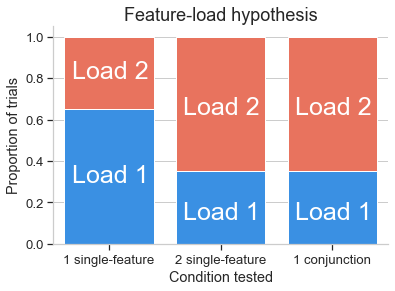

In [362]:
sns.barplot(x=[0,1,2], y=[1,1,1], color='tomato')
ax = sns.barplot(x='labels',y='data',data=feature_model,color='dodgerblue', capsize=.05, order=['1 single-feature','2 single-feature','1 conjunction'])

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.title('Feature-load hypothesis', fontsize = 18)
ax.set_ylabel('Proportion of trials')
ax.set_xlabel('Condition tested')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.text(.01,.3,'Load 1',fontsize=25,c='w',ha='center');
ax.text(1+.01,.12,'Load 1',fontsize=25,c='w',ha='center');
ax.text(2+.01,.12,'Load 1',fontsize=25,c='w',ha='center');

ax.text(.01,.8,'Load 2',fontsize=25,c='w',ha='center');
ax.text(1+.01,.625,'Load 2',fontsize=25,c='w',ha='center');
ax.text(2+.01,.625,'Load 2',fontsize=25,c='w',ha='center');

plt.savefig('output/figures/feature_preds_12.png',dpi=500,bbox_inches='tight')
plt.savefig('output/figures/feature_preds_12.pdf',dpi=500,bbox_inches='tight')

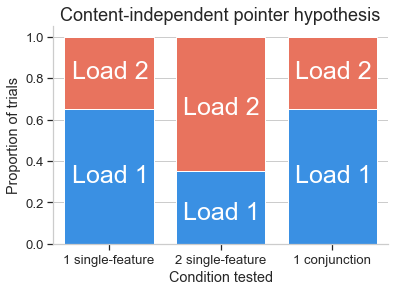

In [363]:
sns.barplot(x=[0,1,2], y=[1,1,1], color='tomato')
ax = sns.barplot(x='labels',y='data',data=pointer_model,color='dodgerblue', capsize=.05, order=['1 single-feature','2 single-feature','1 conjunction'])

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.title('Content-independent pointer hypothesis', fontsize = 18)
ax.set_ylabel('Proportion of trials')
ax.set_xlabel('Condition tested')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.text(.01,.3,'Load 1',fontsize=25,c='w',ha='center');
ax.text(1+.01,.12,'Load 1',fontsize=25,c='w',ha='center');
ax.text(2+.01,.3,'Load 1',fontsize=25,c='w',ha='center');

ax.text(.01,.8,'Load 2',fontsize=25,c='w',ha='center');
ax.text(1+.01,.625,'Load 2',fontsize=25,c='w',ha='center');
ax.text(2+.01,.8,'Load 2',fontsize=25,c='w',ha='center');

plt.savefig('output/figures/pointer_preds_12.png',dpi=500,bbox_inches='tight')
plt.savefig('output/figures/pointer_preds_12.pdf',dpi=500,bbox_inches='tight')

## Set size 2vs4

In [364]:
sing2 = get_norm_sub_means(sing_conf,ss_pair='2vs4',ss=2)
sing4 = get_norm_sub_means(sing_conf,ss_pair='2vs4',ss=4)
conj2 = get_norm_sub_means(conj_conf,ss_pair='2vs4',ss=2)

sing2_percent1 = np.mean(sing2,0)[0]
sing4_percent1 = np.mean(sing4,0)[0]
conj2_percent1 = np.mean(conj2,0)[0]

In [365]:
data = np.concatenate([sing2[:,0],sing4[:,0],conj2[:,0]]).T
labels = np.repeat(['2 single-feature','4 single-feature','2 conjunction'],sing2.shape[0])
data_for_plotting = pd.DataFrame({'data':data,'labels':labels})

In [366]:
data_for_plotting.groupby('labels').mean().round(2)

,data
labels,
2 conjunction,0.68
2 single-feature,0.66
4 single-feature,0.34


In [367]:
data_for_plotting.groupby('labels').std().round(2)

,data
labels,
2 conjunction,0.15
2 single-feature,0.08
4 single-feature,0.08


In [368]:
# 2 single feature vs 4 conjunction
pingouin.ttest(    
    x=data_for_plotting[data_for_plotting['labels']=='2 single-feature']['data'],
    y=data_for_plotting[data_for_plotting['labels']=='2 conjunction']['data'],
    paired=True).round(4)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.652,19,two-sided,0.5222,"[-0.09, 0.05]",0.1848,0.281,0.1231


In [317]:
# 2 single feature vs 4 conjunction
pingouin.ttest(    
    x=data_for_plotting[data_for_plotting['labels']=='4 single-feature']['data'],
    y=data_for_plotting[data_for_plotting['labels']=='2 conjunction']['data'],
    paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-8.05551,19,two-sided,1.512141e-07,"[-0.42, -0.25]",2.760365,1.016e+05,1.0


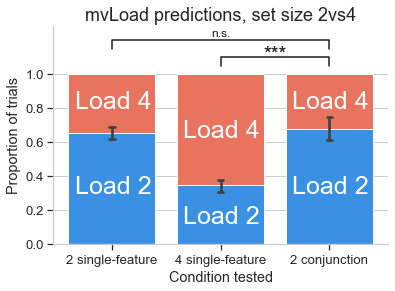

In [370]:
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

sns.barplot(x=[0,1,2], y=[1,1,1], color='tomato')
ax = sns.barplot(x=labels,y=data,data=data_for_plotting,color='dodgerblue', capsize=.05)

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.title('mvLoad predictions, set size 2vs4', fontsize=18)
ax.set_ylabel('Proportion of trials')
ax.set_xlabel('Condition tested')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.text(.01,.3,'Load 2',fontsize=25,c='w',ha='center');
ax.text(1+.01,.12,'Load 2',fontsize=25,c='w',ha='center');
ax.text(2+.01,.3,'Load 2',fontsize=25,c='w',ha='center');

ax.text(.01,.8,'Load 4',fontsize=25,c='w',ha='center');
ax.text(1+.01,.625,'Load 4',fontsize=25,c='w',ha='center');
ax.text(2+.01,.8,'Load 4',fontsize=25,c='w',ha='center');

# statistical annotation
stat_y,stat_h = 1.05, .05
plt.plot([1, 1, 2, 2], [stat_y,stat_y+stat_h,stat_y+stat_h,stat_y], lw=1.5, c='k')
plt.text(1.5, stat_y+stat_h-.04, "***", ha='center', va='bottom', color='k', fontsize=20)

stat_y,stat_h = 1.15, .05
plt.plot([0, 0, 2, 2], [stat_y,stat_y+stat_h,stat_y+stat_h,stat_y], lw=1.5, c='k')
plt.text(1, stat_y+stat_h+.013, 'n.s.', ha='center', va='bottom', color='k', fontsize=12)

plt.ylim(0,1.28)
plt.yticks(np.arange(0,1.01,.2));
plt.savefig('output/figures/mvload_preds_24.png',dpi=500,bbox_inches='tight')
plt.savefig('output/figures/mvload_preds_24.pdf',dpi=500,bbox_inches='tight')